# FFT: Norm

Using FFT as approximation for analytical Fourier transforms poses the problem of normalization: Generally, applying FFT to a time domain sample of a function $g$ will **not** produce a sample of the (approximation of the) frequency domain function $\tilde{g}$ but a multiple thereof. The factor by that the FFT result is off will usually be a function of the number of sampling points.

This notebook presents a normalization for FFTs calculated with routines provided by the `numpy` library that achieves direct comparibility of analytical and numerical FT results.

## Import stuff

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from numpy import fft

In [3]:
import sys
sys.path.append('../packages/')
from normal_distribution import *
from auxiliary import swap_center_border

## Define function and plot function sample

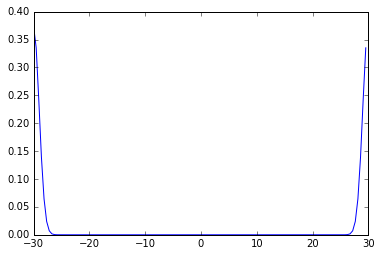

In [4]:
# Define normal distribution
sigma   = 1.
mu      = 0.
fct_g   = make_normal_distribution_density(sigma, mu)

# Define time domain
tres    = 128
tmin    = -30.*sigma
tmax    = -tmin*(tres-2)/tres
t       = np.linspace(tmin, tmax, tres)

# Calculate and plot sample
g       = fct_g(t)
g       = swap_center_border(g)
g       = 2.*g/np.sum(g)
plt.plot(t, g)


## Define analytical FT

In [5]:
# Define analytical FT of above normal distribution
sigma_f = 1./2./np.pi/sigma
mu_f    = 0.
fct_G_f = make_normal_distribution_density(sigma_f, mu_f, normalization=False, prefactor=1.)

## Calculate normalized FFT and compare to analytical FT

Using the `norm='ortho'` keyword argument in `numpy.fft.fft()`, the correct normalization factor for the FFT to compare it with analytical results is:

\begin{equation}
    \frac{\sqrt{n \cdot 2 \pi}}{\sum_{m=0}^{n-1} a_m},
\end{equation}

where $n$ is the number of sampling points and the $a_m$ are the sampling values representing the time domain function $g$. This means that if $t$ is a proper array of well chosen sampling times and $A$ and $A'$ are defined as in this pseudo code:

\begin{align}
    a &= g(t) \\
    A &= \sqrt{n \cdot 2 \pi} \quad / \quad \mathrm{sum}(a) \quad \cdot \quad \mathrm{fft}(a, \mathrm{norm='ortho'}) \\
    \\
    f &= \mathrm{fftfreq}(t) \\
    A' &= \mathcal{g}(f),
\end{align}

then $A$ and $A'$ are essentially the same. 

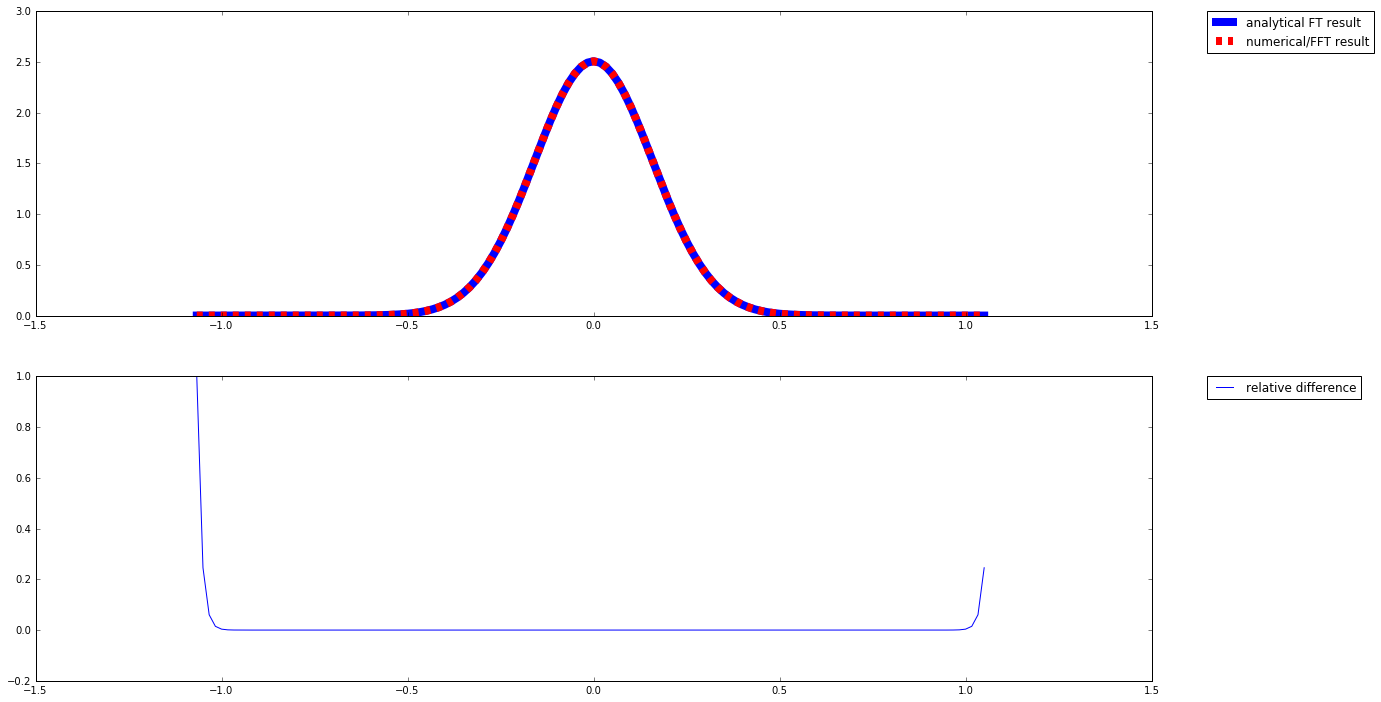

In [6]:
# Calculate FFT
N       = np.sqrt(tres)*np.sqrt(2.*np.pi)/np.sum(g) # normalization factor
G       = N * fft.fftshift(fft.fft(g, norm='ortho'))
f       =     fft.fftshift(fft.fftfreq(tres, t[1]-t[0]))

# Calculate sample of analytical FT
G_f     = fct_G_f(f)



# Plot
fig = plt.figure(figsize=(20, 12))
sub1 = fig.add_subplot(2, 1, 1)
sub1.plot(f, np.real(G_f), 'b-',  linewidth=8, label='analytical FT result')
sub1.plot(f, np.real(G),   'r--', linewidth=8, label='numerical/FFT result')
sub1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sub2 = fig.add_subplot(2, 1, 2)
sub2.plot(f, (np.real(G)-np.real(G_f)) / np.real(G_f), 'b-', label='relative difference')
sub2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Normalization and inverse FFT

Using the `norm='ortho'` keyword argument in `numpy.fft.ifft()`, the correct normalization factor for the inverse FFT to compare it with analytical results is:

\begin{equation}
    \frac{\sqrt{n}}{\sqrt{2 \pi} \cdot \sum_{k=0}^{n-1} A_k},
\end{equation}

where $n$ is the number of sampling points and the $A_k$ are the sampling values representing the frequency domain function $\tilde{g}$. This means that if $f$ is a proper array of well chosen sampling times and $a$ and $a'$ are defined as in this pseudo code:

\begin{align}
    A &= \tilde{g}(f) \\
    a &= \sqrt{n} \quad / \quad \sqrt{2 \pi} \quad / \quad \mathrm{sum}(A) \quad \cdot \quad \mathrm{ifft}(A, \mathrm{norm='ortho'}) \\
    \\
    a' &= \mathcal{g}(t),
\end{align}

then $a$ and $a'$ are essentially the same.

When using FFT and IFFT consequtively, it is important to sum over the generally complex values $a_m$ or $A_k$ in the calculations of the normalization factors rather than their absolutes!

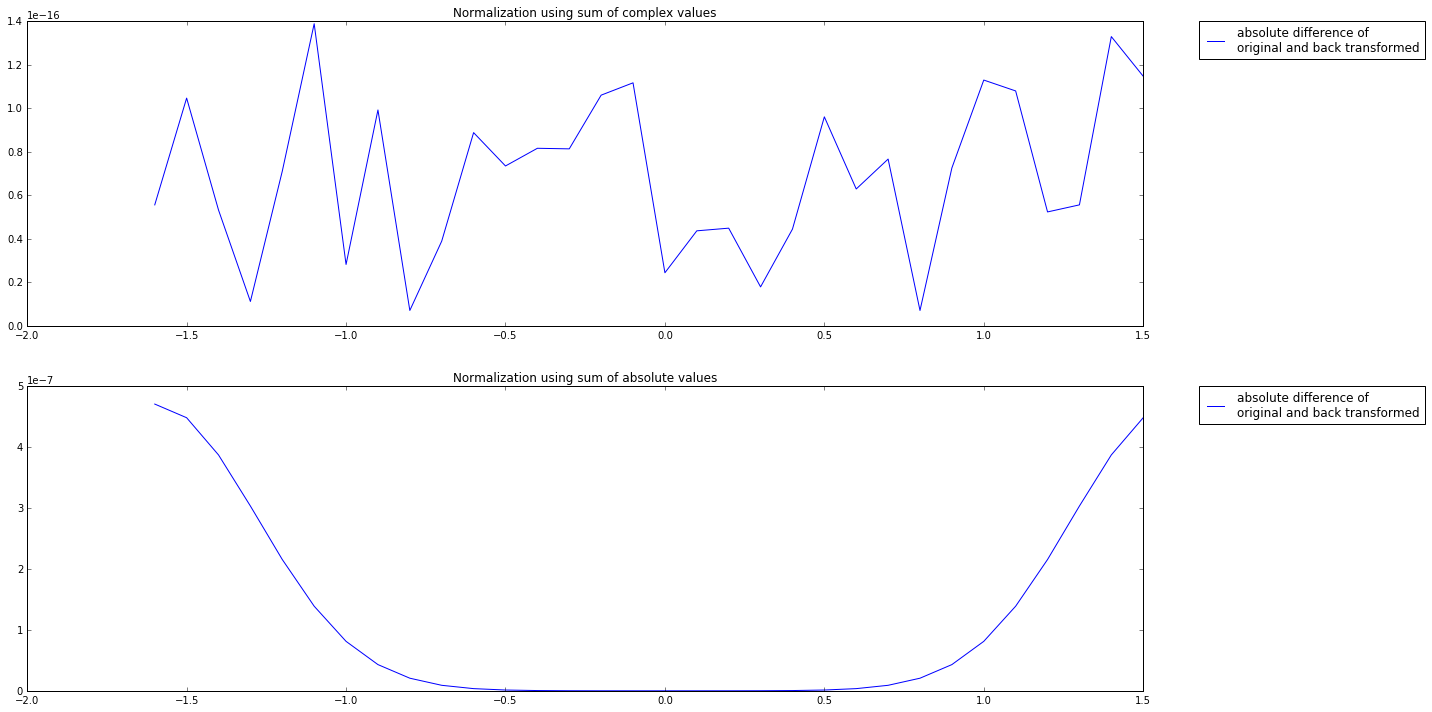

In [7]:
# Define function
sigma  = 1.
mu     = 0.
fct_g  = make_normal_distribution_density(sigma, mu)

# Define time domain
tres   = 32
tmin   = -5.*sigma
tmax   = -tmin * (tres-2) / tres
t      = np.linspace(tmin, tmax, tres)

# Create function sample
g      = fct_g(t)
g      = swap_center_border(g)

# Calculate normalized FFT of sample
N_cmx  = np.sqrt(tres)*np.sqrt(2.*np.pi)/np.sum(g)
G_cmx  = N_cmx * fft.fft(      g, norm='ortho')
G_cmx  =         fft.fftshift( G_cmx)

N_abs  = np.sqrt(tres)*np.sqrt(2.*np.pi)/np.sum(np.abs(g))
G_abs  = N_abs * fft.fft(      g, norm='ortho')
G_abs  =         fft.fftshift( G_abs)

f      = fft.fftfreq(tres, t[1]-t[0])
f      = fft.fftshift(f)

# Calculate normalized IFFT of normalized FFT of sample
NN_cmx = np.sqrt(tres)/np.sqrt(2.*np.pi)/np.sum(G_cmx)
G_cmx  =        fft.ifftshift(G_cmx)
gg_cmx = NN_cmx * fft.ifft(   G_cmx, norm='ortho')

NN_abs = np.sqrt(tres)/np.sqrt(2.*np.pi)/np.sum(np.abs(G_abs))
G_abs  =        fft.ifftshift(G_abs)
gg_abs = NN_abs * fft.ifft(   G_abs, norm='ortho')



# Plot
fig = plt.figure(figsize=(20, 12))

sub1 = fig.add_subplot(2, 1, 1)
sub1.set_title('Normalization using sum of complex values')
sub1.plot(f, np.abs(g-gg_cmx), label='absolute difference of\noriginal and back transformed')
sub1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sub2 = fig.add_subplot(2, 1, 2)
sub2.set_title('Normalization using sum of absolute values')
sub2.plot(f, np.abs(g-gg_abs), label='absolute difference of\noriginal and back transformed')
sub2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
